# Fitting and prediting - Frequency data

RHEOS can also fit models to dynamic mechanical analysis data from oscillatory tests (more information about dynamic test can be found in XXX).

In [4]:
using RHEOS

## Fitting

**Step 1: Loading of the experimental data**

RHEOS has a convenient function to import data from CSV files (more information in [File I/O](@ref) section).

In [5]:
data = importcsv("data_freq.csv", ω_col=1, Gp_col=2, Gpp_col=3);
RheoFreqDataType(data)

┌ Warning: Please note that NaN data rows are not included in resultant data struct.
└ @ RHEOS /home/alessandra/.julia/dev/RHEOS/src/IO.jl:11


with_modulus::FreqDataType = 1

The frequency, storage modulus and loss modulus are stored into a RheoFreqData strut. 

**Step 2: Model fit**

Let's fit a Fractional Kelvin-Voigt model. The first argument is our data, the second argument tells RHEOS which model to fit (RheoModelClass). The function will return a RheoModel object, thus a RheoModelClass with fixed values for the parameters. The function [`dynamicmodelfit`](@ref) possess all the additional arguments (lower and upper bounds, initial parameters, tollerance) as for the fitting of time data.

In [6]:
# Lower bounds
Lo = (cₐ=0.0, a=0.01, cᵦ=0.0, β = 0.01)
# Upper bounds
Hi = (cₐ=1e2, a=0.99, cᵦ=1e2, β = 0.99)
# Initial parameters
P0 = (cₐ=1.0, a=0.36, cᵦ=1.0, β = 0.03)

FractKV_model = dynamicmodelfit(data, Fract_KelvinVoigt, weights = "log", lo = Lo, hi = Hi, p0 = P0)

┌ Warning: Note that a logarithmic rescaling will fail if Gp or Gpp data contain 0.0 values as it will result in -Inf cost. Trying a different rescaling scheme, or not fitting around ω≈0.0 may alleviate the issue.
└ @ RHEOS /home/alessandra/.julia/dev/RHEOS/src/processing.jl:714


Time: 0.385953893 s, Why: XTOL_REACHED, Parameters: [0.00921903, 0.770062, 0.913296, 0.100392], Error: 0.34215629087463373


Model: fractKV

Parameter values: (cₐ = 0.009219028112809006, a = 0.7700618789054214, cᵦ = 0.9132958174053891, β = 0.10039200856098299) 

                ________ ╱╲ ________
               |         ╲╱  cₐ, a  |
           ____|                    |____
               |                    |
               |________ ╱╲ ________|
                         ╲╱  cᵦ, β
                

For the fitting process RHEOS relies on the optimistion package [NLopt.jl](https://nlopt.readthedocs.io/en/latest/). RHEOS makes use of a local derivative free algorithm, specifically the Tom Rowan's "Subplex" algorithm originally introduced in 
+ T. Rowan, "Functional Stability Analysis of Numerical Algorithms", Ph.D. thesis, Department of Computer Sciences, University of Texas at Austin, 1990.

The storage and loss moduli can sometimes occupy different orders of magnitude. This can cause problems during fitting as the optimisation routine will weight errors at the higher orders of magnitude more strongly than those at the lower orders of magnitude. This is a more general problem often faced during multi-objective optimisation problems. RHEOS offers four rescaling options (weight):

+ The global option rescales the cost at each point by the point itself ("local"). 
+ The logarithmic approach simply re-scales all the storage and loss moduli and their predicted values logarithmically before finding the error between them ("log"). 
+ A third option in RHEOS divides the cost at each point by the mean value of the storage and loss modulus respectively depending on which cost is being calculated. This can work well but performance is hindered if the storage or loss moduli individually vary over many orders of magnitude ("mean"). 
+ The fourth option offered by RHEOS is simply manual weightings provided by the user for each modulus ("manual"). 

In the first two cases, the benefit arises from the fact that the optimisation weighting is rebalanced in favour of smaller values. The logarithmic rescaling method seems to work particularly well but runs into problems if the storage or loss moduli are exactly 0 at any frequency, this is due to the negative singularity of the logarithmic function for the 0 argument. 


## Predicting

RHEOS allows the user to simulate the frequency response of a model (with defined parameters, RheoModel strut) to an imposed loading. 

Given an incomplete data set (frequency only) and model with values substituted into parameters (RheoModel), return a new "complete" dataset based on the model with the simulated missing variable (storage and loss).

**Assess quality of the fit**

The ability of predicting model's response is first exploited to assess the quality of the fits above.
The incomplete RheoFreqData variable is defined by extracting the frequency from the original data or by defining a new frequency vector.

In [7]:
data_ext = extract(data,freq_only);
# Alternatively, a RheoFreqData with only frequency data can be generated as
# data_gen = frequencyspec(ω_start=1.0e-2, ω_end=1.0e2, step=1.0e-5)

RheoFreqDataType(data_ext)

freq_only::FreqDataType = 0

For the prediction, RHEOS' function [`dynamicmodelpredic`](@ref) requires the incomplete data set and a model with fixed parameters (RheoModel). For the assessment of the fitting quality the RheoModel is the output of the fitting function. 

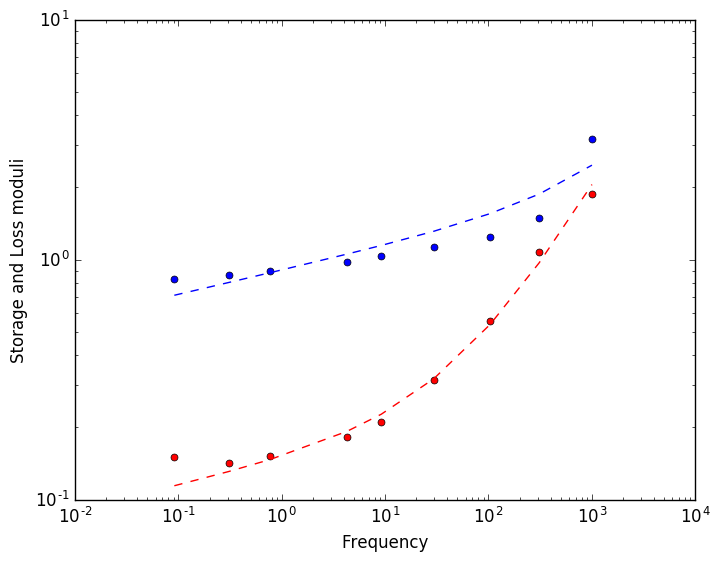

In [10]:
fractKV_predict = dynamicmodelpredict(data_ext, FractKV_model)

# Now we can plot data and model together for comparison
using PyPlot
loglog(data.ω, data.Gp, "o", markersize = 5, color="blue");
loglog(data.ω, data.Gpp, "o", markersize = 5, color = "red");
loglog(fractKV_predict.ω, fractKV_predict.Gp, "--", color="blue");
loglog(fractKV_predict.ω, fractKV_predict.Gpp, "--", color="red");
xlabel("Frequency");
ylabel("Storage and Loss moduli");

**Simulate different model behaviours**

The ability of predicting model's response can be exploited to simulate the behaviour of the model to other external loading conditions. For example, we will explore the response of the fitted model to a creep experiment. 

First we need to define an incomplete RheoTimeData strut, which can be achieved via the data generation functions provided in RHEOS (see section [Generating data](@ref)).

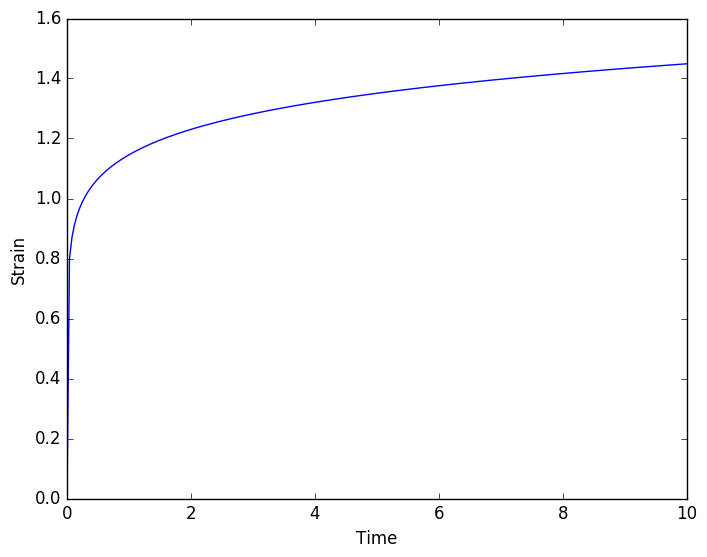

In [13]:
# Define timeline
dσ = timeline()
# and a step in stress
dσ = stressfunction(dσ,hstep())

# we can now predict the creep response of the Maxwell model 
FractKV_creepPredict = modelsteppredict(dσ,FractKV_model)
# Visualisation of the simulated response
plot(FractKV_creepPredict.t,FractKV_creepPredict.ϵ);
xlabel("Time");
ylabel("Strain");

**Reference frequency data**: Deng, Linhong, et al. "Fast and slow dynamics of the cytoskeleton." Nature materials 5.8 (2006): 636.